In [1]:
!pip install --upgrade pip
!pip install pandas numpy seaborn matplotlib nltk keras wordcloud scikit-learn

In [2]:
#importing the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string, os
import nltk
import re
import keras
import random
import io
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
import sys
# from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image, ImageDraw, ImageFont

from IPython import display
from IPython.display import Markdown as md


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


<a id="2"></a>
# <p style="background-color:#B291B6;font-family:newtimeroman;color:#444160;font-size:150%;text-align:center;border-radius:20px 60px;">LOADING DATA</p>
For this project, I have prepared a dataset of song lyrics. Let's load it and have a look.

In [3]:
data = pd.read_csv("Songs.csv")
data.head()

,Artist,Title,Lyrics
0,Taylor Swift,cardigan,"Vintage tee, brand new phone\nHigh heels on co..."
1,Taylor Swift,exile,"I can see you standing, honey\nWith his arms a..."
2,Taylor Swift,Lover,We could leave the Christmas lights up 'til Ja...
3,Taylor Swift,the 1,"I'm doing good, I'm on some new shit\nBeen say..."
4,Taylor Swift,Look What You Made Me Do,I don't like your little games\nDon't like you...


<a id="3"></a>
# <p style="background-color:#B291B6;font-family:newtimeroman;color:#444160;font-size:150%;text-align:center;border-radius:20px 60px;">DATA EXPLORATION</p>

**In this section, I will be:**
* Exploring the various artists in data
* Explore the number of songs and their corresponding information
* Explore the various words in lyrics via wordcloud 

In [4]:
#Printing the names of artists in the lyrics data
print("Artists in the data:\n",data.Artist.value_counts()) 

Artists in the data:
 Taylor Swift          50
David Bowie           50
Billy Joel            50
Eric Clapton          50
Billie Eilish         50
Leonard Cohen         50
Bruce Springsteen     40
The Beatles           35
Ray LaMontagne        30
Elton John            30
Queen                 30
Frank Sinatra         30
John Denver           30
Bryan Adams           30
​twenty one pilots    30
Nat King Cole         30
Lana Del Rey          30
Vance Joy             30
George Michael        30
Bob Dylan             20
Ed Sheeran            20
Name: Artist, dtype: int64


In [5]:
#Printing the size of dataset
print("Size of Dataset:",data.shape)

Size of Dataset: (745, 3)


So I have a total of 745 songs

**I will do a little feature engineering to extract more information on the songs such as:**
* Number of characters
* Number of words
* Number of lines

In [6]:
nltk.download('punkt')
#Adding a column of numbers of Characters,words and sentences in each msg
data["No_of_Characters"] = data["Lyrics"].apply(len)
data["No_of_Words"]=data.apply(lambda row: nltk.word_tokenize(row["Lyrics"]), axis=1).apply(len)
data["No_of_Lines"] = data["Lyrics"].str.split('\n').apply(len)
data.describe()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,No_of_Characters,No_of_Words,No_of_Lines
count,745.000000,745.000000,745.000000
mean,1403.347651,319.383893,46.277852
std,666.721467,156.072565,21.180531
min,1.000000,1.000000,1.000000
25%,946.000000,215.000000,33.000000
50%,1289.000000,291.000000,44.000000
75%,1714.000000,389.000000,56.000000
max,7267.000000,1652.000000,224.000000


To be noted: On average our songs have 1400-ish characters

<Figure size 1080x1080 with 0 Axes>

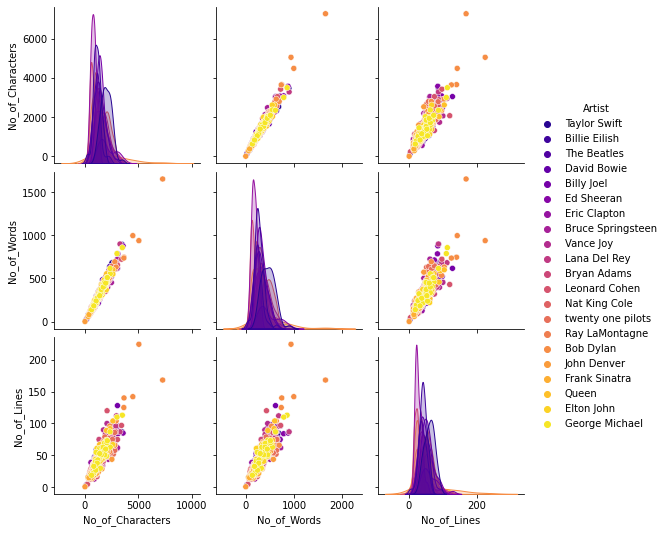

In [7]:
#Plotting the comparative song lengths for various artists
plt.figure(figsize=(15,15))
ax = sns.pairplot(data, hue="Artist", palette="plasma")

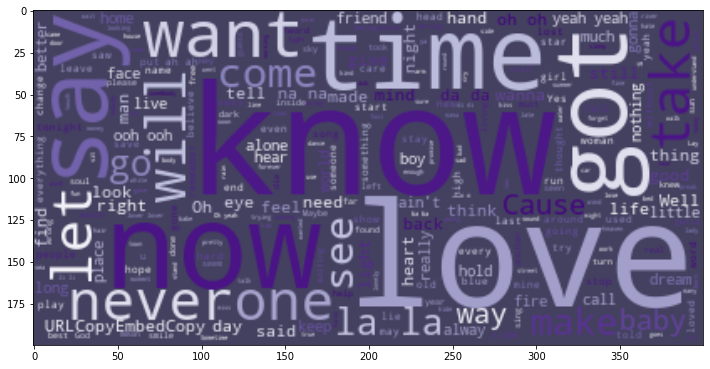

In [8]:
# Generate a word cloud image
from nltk.corpus import stopwords

stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="#444160",colormap="Purples", max_words=800).generate(" ".join(data["Lyrics"]))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()

The generation of text with RNN involves the following workflow.  

<p style="background-color:#B3C5E3;font-family:newtimeroman;color:#444160;text-align:center;font-size:120%;">Loading Data ➡️ Preprocessing ➡️ Building Mapping Dictionary ➡️ Building Model ➡️ Generating Text</p>

As I have loaded and explored the data,  I will proceed further by pre-processing the text.  


<a id="4"></a>
# <p style="background-color:#B291B6;font-family:newtimeroman;color:#444160;font-size:150%;text-align:center;border-radius:20px 60px;">DATA PREPROCESSING</p>

**In this section, I will be performing the following:**

**Creating a Corpus of Lyrics text:** For the model, we need a sequence of the text string. I am creating a Corpus out of Lyrics column. 

**Removing the unrequired characters that may have sneaked in my text corpus:** The data cleaning process for NLP is crucial preprocessing. To do that, I look into the Corpus to check for what this Corpus is comprised of. That is, all the unique symbols present. After examining the Corpus, I will be eliminating any foreign language or irrelevant symbols from the Corpus. 

**Creating a dictionary to map characters and their indices:** The computer doesn’t understand the text. For the computer, the text is just a cluster of symbols. It works with numbers. So we create a dictionary to map each unique character in our Corpus to a number and vice versa. This will be used to encode and decode the information going in and getting out of the RNN

**Splitting the corpus into smaller sentences of equal length:** Encoding and splitting the corpus into smaller sequences of equal length: At this point, Corpus contain only intended characters (i.e, lower cap English alphabets, Numbers and a few punctuations). We will encode this corpus and create small sequences of equal lengths of features and the corresponding targets. Each feature and target will contain the mapped index in the dictionary of the unique characters they signify. 

The labels are then resized and normalized. Whereas the targets are one-hot encoded. Ready to be sent to the RNN for the training, but before that let us built the RNN model. 

**Creating a Corpus**

In [9]:
#Lining up all the lyrics to create corpus
Corpus =''
for listitem in data.Lyrics:
    Corpus += listitem
    
Corpus = Corpus.lower() #converting all alphabets to lowecase 
print("Number of unique characters:", len(set(Corpus)))

Number of unique characters: 92


The total number of unique characters present in the Corpus clearly shows, that some of the foreign language scripts have sneaked in. I will take a look at all the characters present. I will then remove the unrequired characters. 

In [10]:
def cleanup_text(inp: str)-> str:
    inp = re.sub("[^A-Za-z0-9'\.\n]"," ",inp) # Alterneativly could be used but I want to pick and chose (:
    inp = inp.replace("\'","")
    inp = " ".join([t for t in inp.split() if len(t) > 1])
    return inp

In [11]:
#To See all the unique characters present in the Corpus
print("The unique characters:",sorted(set(Corpus)))

Corpus = cleanup_text(Corpus)
Corpus[:100]

The unique characters: ['\n', ' ', '!', '"', '&', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '>', '?', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '}', '~', '©', 'à', 'á', 'ã', 'ä', 'ç', 'è', 'é', 'ê', 'ë', 'í', 'ñ', 'ó', 'ö', 'ü', 'ŏ', 'е', 'ا', 'س', 'ل', 'م', 'و', '\u2005', '\u200a', '\u200b', '–', '—', '‘', '’', '‚', '“', '”', '…', '\u205f', '\ufeff']


'vintage tee brand new phone high heels on cobblestones when you are young they assume you know nothi'

**Creating a list of sorted unique characters**

In [12]:
# Storing all the unique characters present in my corpus to bult a mapping dic. 
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 986804
Number of unique characters: 38


In [13]:
#Splitting the Corpus in equal length of strings and output target
length = 15
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
    
L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 986789


**Encoding the Labels and Targets**

In [14]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)

# one hot encode the output variable
y = np_utils.to_categorical(targets)

In [15]:
print(X.shape)
y

(986789, 15, 1)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

<a id="5"></a>
# <p style="background-color:#B291B6;font-family:newtimeroman;font-size:150%;color:#444160;text-align:center;border-radius:20px 60px;">MODEL BUILDING</p>


Recurrent Neural Networks are pretty popular with generating text. In this project, I will be using a LSTM Model, an improved version of a standard recurrent neural network

**Following steps are involved in the model building**

* Initialising the Model
* Defining by adding layers
* Compiling the Model
* Training the Model

**Building the Model**

In [16]:
#Initialising the Model
model = Sequential()
#Adding layers
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(y.shape[1], activation='softmax'))
#Compiling the model for training  
opt = RMSprop(learning_rate=0.001, momentum=0.1)
model.compile(loss='categorical_crossentropy', optimizer=opt)

#Model's Summary               
model.summary()



2021-11-29 07:49:45.178593: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-29 07:49:45.190363: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-29 07:49:45.191254: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-29 07:49:45.193477: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-29 07:49:45.194354: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read f

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               264192    
_________________________________________________________________
dense (Dense)                (None, 38)                9766      
Total params: 273,958
Trainable params: 273,958
Non-trainable params: 0
_________________________________________________________________


In [17]:
#Training the Model
history = model.fit(X, y, batch_size=128, epochs=50)

2021-11-29 07:49:47.515734: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2021-11-29 07:49:49.404199: I tensorflow/stream_executor/cuda/cuda_dnn.cc:381] Loaded cuDNN version 8204


7710/7710 [==============================] - 56s 7ms/step - loss: 2.4924
Epoch 2/50
7710/7710 [==============================] - 53s 7ms/step - loss: 2.2519
Epoch 3/50
7710/7710 [==============================] - 53s 7ms/step - loss: 2.0003
Epoch 5/50
7710/7710 [==============================] - 53s 7ms/step - loss: 1.9159
Epoch 6/50
7710/7710 [==============================] - 53s 7ms/step - loss: 1.8496
Epoch 7/50
7710/7710 [==============================] - 53s 7ms/step - loss: 1.7955
Epoch 8/50
7710/7710 [==============================] - 53s 7ms/step - loss: 1.7515
Epoch 9/50
7710/7710 [==============================] - 53s 7ms/step - loss: 1.7132
Epoch 10/50
7710/7710 [==============================] - 53s 7ms/step - loss: 1.6817
Epoch 11/50
7710/7710 [==============================] - 54s 7ms/step - loss: 1.6533
Epoch 12/50
7710/7710 [==============================] - 53s 7ms/step - loss: 1.6284
Epoch 13/50
7710/7710 [==============================] - 54s 7ms/step - loss: 1.6064

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



7710/7710 [==============================] - 54s 7ms/step - loss: 1.4005
Epoch 34/50
7710/7710 [==============================] - 53s 7ms/step - loss: 1.3953
Epoch 35/50
7710/7710 [==============================] - 53s 7ms/step - loss: 1.3907
Epoch 36/50
7710/7710 [==============================] - 53s 7ms/step - loss: 1.3863
Epoch 37/50
7710/7710 [==============================] - 54s 7ms/step - loss: 1.3816
Epoch 38/50
7710/7710 [==============================] - 54s 7ms/step - loss: 1.3777
Epoch 39/50
7710/7710 [==============================] - 53s 7ms/step - loss: 1.3740
Epoch 40/50
7710/7710 [==============================] - 54s 7ms/step - loss: 1.3698
Epoch 41/50
7710/7710 [==============================] - 54s 7ms/step - loss: 1.3665
Epoch 42/50
7710/7710 [==============================] - 54s 7ms/step - loss: 1.3628
Epoch 43/50
7710/7710 [==============================] - 53s 7ms/step - loss: 1.3592
Epoch 44/50
7710/7710 [==============================] - 54s 7ms/step - loss:

In [24]:
from keras.models import load_model
#To be used later; I am saving the model 
model.save("Lyrics_Generator.h5")

<a id="6"></a>
# <p style="background-color:#B291B6;font-family:newtimeroman;font-size:150%;color:#444160;text-align:center;border-radius:20px 60px;">EVALUATING MODELS</p>

Now that I have my model trained on the songs lyrics let us see how it performs. I hope it creates some sensible song.

**To evaluate my model, I shall be having a look at:**
* The performance of the model via Learning Curves
* The outcome text it generates

**Plotting the learning curve for the loss function**

[Text(0.5, 0, 'Epochs')]

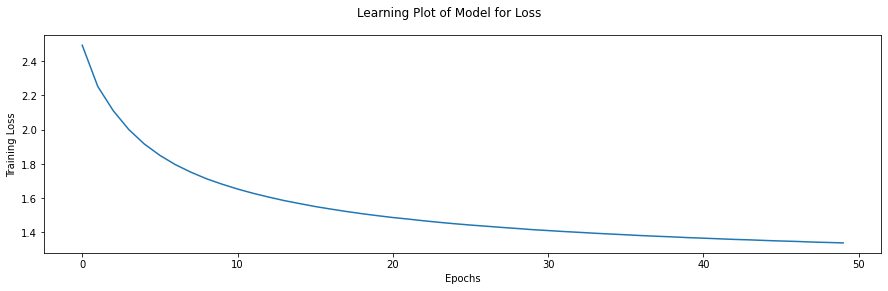

In [25]:
history_df = pd.DataFrame(history.history)
#Plotting the learnings 

fig = plt.figure(figsize=(15,4))
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"])
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

**Generating the songs**

In [26]:
# The function to generate text from model
def Lyrics_Generator(starter,Ch_count): #,temperature=1.0):
    generated= ""
    starter = cleanup_text(starter) 
    print(starter)
    
    seed=[mapping[char] for char in starter]
    generated += starter 
    # Generating new text of given length
    for i in range(Ch_count):
        seed=[mapping[char] for char in starter]
        x_pred = np.reshape(seed, (1, len(seed), 1))
        x_pred = x_pred/ float(L_symb)
        prediction = model.predict(x_pred, verbose=0)[0]  
        # Getting the index of the next most probable index
        prediction = np.asarray(prediction).astype('float64')
        prediction = np.log(prediction) / 1.0 
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        probas = np.random.multinomial(1, prediction, 1)
        index = np.argmax(prediction)
        next_char = reverse_mapping[index]  
        # Generating new text
        generated += next_char
        starter = starter[1:] + next_char
       
    return generated

Let us finally see the outcome by putting a seed in from one of my old blogposts [blogpost](https://karnikakapoor.blogspot.com/2017/04/killers-confession.html)

In [35]:
#Generating a song from the model
song_1 = Lyrics_Generator("i'm the bad guy", 50)
#Let's have a look at the song
song_1

im the bad guy


'im the bad guy rhe savs she says the way that keaps the stars an'

Another song generated by a seed of the lyrics of a song that's stuck in my head today. (Sunflower by Shannon Purser)

In [33]:
#Generating a song from the model using a song out of the corpus
song_2 = Lyrics_Generator("i'm a sunflower, a little funny", 50)
#Let's have a look at the song
song_2

im sunflower little funny


'im sunflower little funny that you want you to the heart you know it is tha'

<a id="7"></a>
# <p style="background-color:#B291B6;font-family:newtimeroman;font-size:150%;color:#444160;text-align:center;border-radius:20px 60px;">CONCLUSION</p>
<p style="font-family:newtimeroman;font-size:120%;color:#444160">On observing the output of the Lyrics Generator, it is clear that while some of the sentences might be correct, but most of the lyrics do not make sense. It does look like a song tho. The model didn't learn the meaning of the songs. However, the character-based approach is producing some legitimate words. 
To get to a song that makes better sense I may consider a transformer-based text generator, but that's for some other time.</p>

<p style="font-family:newtimeroman;font-size:120%;color:#444160;"> Neural networks amaze me all the time. There is something surreal about them that makes working with it exciting. Of course, we can peel off the layers and see the maths behind them. Get to the matrices and tensor to understand how these neurons are working. Even get the values of weights and biases and assure ourselves that this is no sorcery.  Still, when I see the result play out it is astonishing.</p>  

**Some useful resources on Text generation:**

[The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

[RNN ](https://towardsdatascience.com/character-level-language-model-1439f5dd87fe)

[GTP-2 ](https://openai.com/blog/better-language-models/) 


**<span style="color:#444160;"> If you liked this Notebook, please do upvote.</span>**

**<span style="color:#444160;"> Best Wishes!</span>**

<a id="8"></a>
# <p style="background-color:#B291B6;font-family:newtimeroman;font-size:150%;color:#444160;text-align:center;border-radius:20px 60px;">END</p>